In [706]:
import numpy as np
from scipy.stats import norm
import scipy.linalg as LA
import scipy.optimize as opt
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve
import pandas as pd

In [707]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

def f1(x):
    # return np.exp(-0.5 * (x - np.pi)**2)
    return 0.5 * x + 1.0
    # return np.tanh(x)
    # return np.log(x + 1)

def f2(x):
    return np.sin(2 * x)

X_train = np.sort(np.random.choice(np.linspace(0, 2 * np.pi, 200), size=30, replace=False)).reshape(-1, 1)
X_pool = np.linspace(0.01, 4 * np.pi, 400)
X_test_candidates = np.setdiff1d(np.round(X_pool, 4), np.round(X_train.flatten(), 4))
X_test = np.sort(np.random.choice(X_test_candidates, size=200, replace=False)).reshape(-1, 1)

noise_std_1 = 0.1
noise_std_2 = 0.1

y1_train = f1(X_train).reshape(-1, 1) + np.random.normal(0, noise_std_1, size=(X_train.shape[0], 1))
y2_train = f2(X_train).reshape(-1, 1) + np.random.normal(0, noise_std_2, size=(X_train.shape[0], 1))

y1_test = f1(X_test).reshape(-1, 1)
y2_test = f2(X_test).reshape(-1, 1)

In [708]:
y1_test

array([[1.005  ],
       [1.03645],
       [1.0994 ],
       [1.1466 ],
       [1.16235],
       [1.1781 ],
       [1.20955],
       [1.241  ],
       [1.28825],
       [1.3197 ],
       [1.35115],
       [1.3669 ],
       [1.38265],
       [1.42985],
       [1.44555],
       [1.4613 ],
       [1.47705],
       [1.52425],
       [1.61865],
       [1.6344 ],
       [1.65015],
       [1.66585],
       [1.6816 ],
       [1.69735],
       [1.7288 ],
       [1.74455],
       [1.80745],
       [1.8547 ],
       [1.8704 ],
       [1.9176 ],
       [1.9491 ],
       [1.9648 ],
       [1.9963 ],
       [2.0435 ],
       [2.07495],
       [2.10645],
       [2.12215],
       [2.1379 ],
       [2.15365],
       [2.1851 ],
       [2.20085],
       [2.2166 ],
       [2.2323 ],
       [2.24805],
       [2.2638 ],
       [2.2795 ],
       [2.29525],
       [2.311  ],
       [2.3267 ],
       [2.3582 ],
       [2.37395],
       [2.38965],
       [2.4054 ],
       [2.42115],
       [2.4526 ],
       [2.

In [709]:
a = np.linspace(0, 2*np.pi, 200)
b = np.linspace(0.01, 4*np.pi, 400)
c = set(a) & set(b)
c

set()

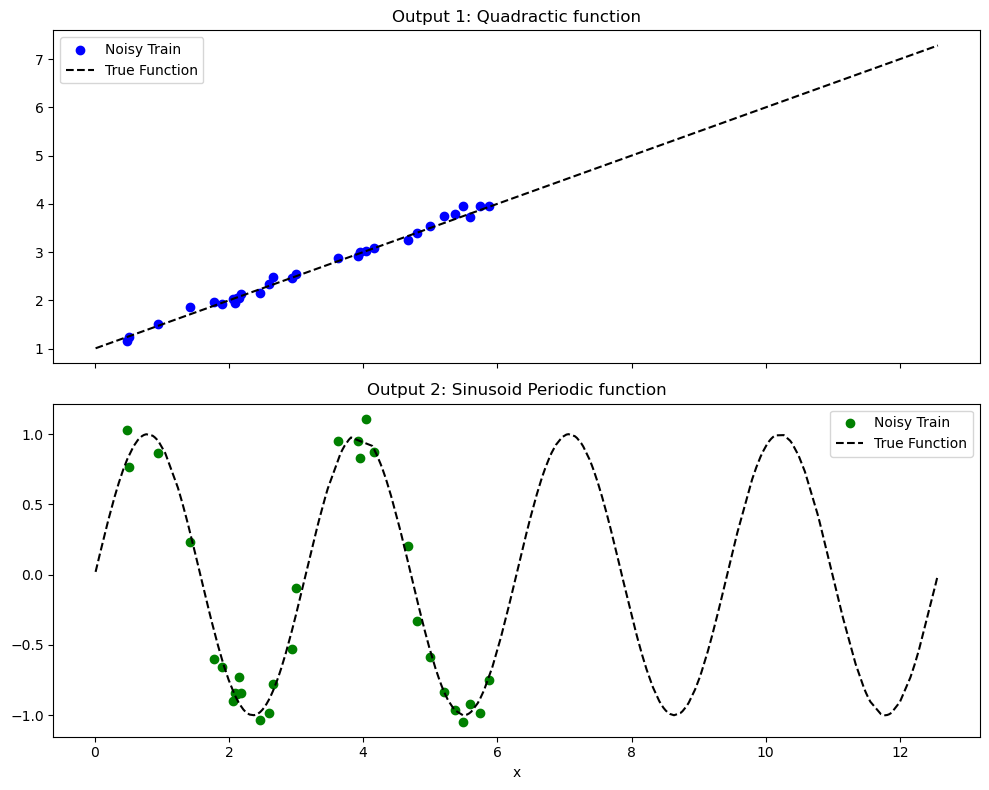

In [710]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axes[0].scatter(X_train, y1_train, color='blue', label='Noisy Train')
axes[0].plot(X_test, y1_test, color='black', linestyle='--', label='True Function')
axes[0].set_title('Output 1: Quadractic function')
axes[0].legend()

axes[1].scatter(X_train, y2_train, color='green', label='Noisy Train')
axes[1].plot(X_test, y2_test, color='black', linestyle='--', label='True Function')
axes[1].set_title('Output 2: Sinusoid Periodic function')
axes[1].legend()

plt.xlabel("x")
plt.tight_layout()
plt.show()

In [711]:
X_train

array([[0.47360693],
       [0.50518073],
       [0.94721387],
       [1.4208208 ],
       [1.76813255],
       [1.89442773],
       [2.05229671],
       [2.0838705 ],
       [2.1154443 ],
       [2.14701809],
       [2.17859189],
       [2.46275605],
       [2.58905123],
       [2.65219882],
       [2.93636298],
       [2.99951057],
       [3.63098648],
       [3.91515064],
       [3.94672444],
       [4.04144583],
       [4.16774101],
       [4.67292174],
       [4.79921692],
       [4.98865969],
       [5.20967626],
       [5.36754524],
       [5.49384042],
       [5.58856181],
       [5.74643078],
       [5.87272597]])

In [712]:
# SOGP vs MOGP
# Case1: (SOGP) Func1 using the RBF kernel, Func2 using the periodic kernel
# Case2: (MOGP) Using two kernel: RBF + Periodic combine

## Case1 SOGP

In [714]:
def periodic_kernel(X1, X2, lengthscale, variance, period):
    X_1 = np.atleast_2d(X1).reshape(-1, 1)
    X_2 = np.atleast_2d(X2).reshape(-1, 1)
    dists = np.abs(X1 - X2.T)
    sin_term = np.sin(np.pi * dists / period)
    return variance**2 * np.exp(-2 * (sin_term**2) / lengthscale**2)

def rbf_kernel(X1, X2, lengthscale, variance):
    X1 = np.atleast_2d(X1) # view the array input X as an matrix 2d
    X2 = np.atleast_2d(X2)

    sqdist = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return variance * np.exp(-0.5 * sqdist / lengthscale**2)

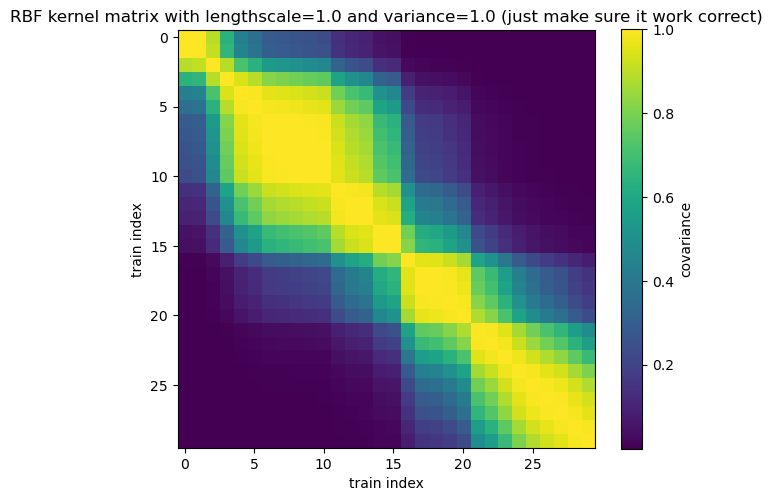

In [715]:
test_rbf = rbf_kernel(X_train, X_train, 1.0, 1.0)
plt.figure(figsize=(6, 5))
plt.imshow(test_rbf, cmap='viridis')
plt.colorbar(label='covariance')
plt.title(f"RBF kernel matrix with lengthscale=1.0 and variance=1.0 (just make sure it work correct)")
plt.xlabel("train index")
plt.ylabel("train index")
plt.tight_layout()
plt.show()

In [716]:
X_train.shape

(30, 1)

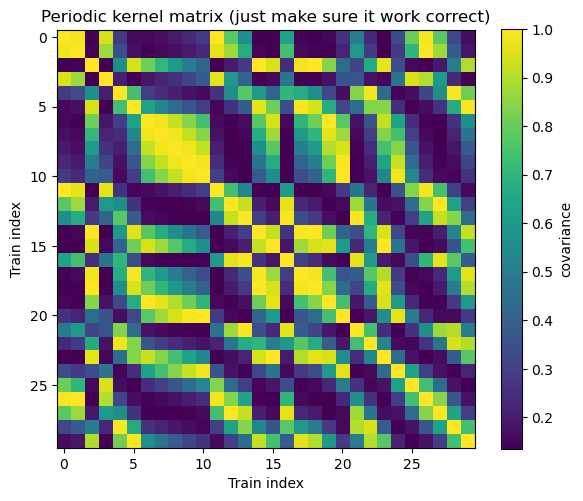

In [717]:
test_rbf = periodic_kernel(X_train, X_train, 1.0, 1.0, 1.0)
plt.figure(figsize=(6, 5))
plt.imshow(test_rbf, cmap='viridis')
plt.colorbar(label='covariance')
plt.title(f"Periodic kernel matrix (just make sure it work correct)")
plt.xlabel("Train index")
plt.ylabel("Train index")
plt.tight_layout()
plt.show()

In [718]:
# using the rbf kernel for function 1
def nll_rbf(params_rbf, X_train, Y_train):
    #get hyper params value
    sigma_f, length_scale_l, noise = params_rbf
    
    # get the covariance matrix
    K = rbf_kernel(X_train, X_train, lengthscale=length_scale_l, variance=sigma_f)
    
    # add noise and a small jiter for stablize the result (make the covariance matrix does not become singular)
    K += (noise**2 + 1e-6) * np.eye(len(X_train))
    
    # cholesky decomp for efficient compute
    L = LA.cholesky(K, lower=True)
    
    # solve to get alpha = K^-1 * y
    alpha = LA.cho_solve((L, True), Y_train)
    
    # get negative log likelihood
    nll = 0.5 * Y_train.T @ alpha + np.sum(np.log(np.diag(L))) + 0.5 * len(X_train) * np.log(2*np.pi)
    return nll.item()

# rbf prediction for the 1st output function
def sogp_rbf_prediction(X_train, X_test, Y_train, optimized_params):
    sigma_f, length_scale_l, noise = optimized_params
    # getting the inverse cov train with cholesky
    K = rbf_kernel(X_train, X_train, lengthscale=length_scale_l, variance=sigma_f)
    
    # add noise and a small jiter for stablize the result (make the covariance matrix does not become singular)
    K += (noise**2 + 1e-6) * np.eye(len(X_train))
    
    # cholesky decomp for efficient compute
    L = LA.cholesky(K, lower=True)
    
    # solve to get alpha = K^-1 * y
    alpha = LA.cho_solve((L, True), Y_train)

    K_s = rbf_kernel(X_train, X_test, lengthscale=length_scale_l, variance=sigma_f)
    #getting the mean: y_test = K_s*K-1*y_train
    mean = K_s.T @ alpha

    K_ss = rbf_kernel(X_test, X_test, lengthscale=length_scale_l, variance=sigma_f)
    v = LA.solve_triangular(L, K_s, lower=True) ## getting the v = L \ K_s
    var = np.diag(K_ss) - np.sum(v**2, axis=0) # getting predict variance
    return mean.ravel(), np.maximum(var, 0)

In [719]:
# periodic kernel and prediction for the others function 
def nll_periodic(params, X_train, Y_train):
    #get hyper params value
    sigma_f, length_scale_l, period_p, noise = params
    
    # get the covariance matrix
    K = periodic_kernel(X_train, X_train, lengthscale=length_scale_l, variance=sigma_f, period=period_p)
    
    # add noise and a small jiter for stablize the result (make the covariance matrix does not become singular)
    K += (noise**2 + 1e-6) * np.eye(len(X_train))
    
    # cholesky decomp for efficient compute
    L = LA.cholesky(K, lower=True)
    
    # solve to get alpha = K^-1 * y
    alpha = LA.cho_solve((L, True), Y_train)
    
    # get negative log likelihood
    nll = 0.5 * Y_train.T @ alpha + np.sum(np.log(np.diag(L))) + 0.5 * len(X_train) * np.log(2*np.pi)
    return nll.item()

def sogp_periodic_prediction(X_train, X_test, Y_train, optimized_params):
    sigma_f, length_scale_l, period_p, noise = optimized_params
    # getting the inverse cov train with cholesky
    K = periodic_kernel(X_train, X_train, lengthscale=length_scale_l, variance=sigma_f, period=period_p)
    
    # add noise and a small jiter for stablize the result (make the covariance matrix does not become singular)
    K += (noise**2 + 1e-6) * np.eye(len(X_train))
    
    # cholesky decomp for efficient compute
    L = LA.cholesky(K, lower=True)
    
    # solve to get alpha = K^-1 * y
    alpha = LA.cho_solve((L, True), Y_train)

    K_s = periodic_kernel(X_train, X_test, lengthscale=length_scale_l, variance=sigma_f, period=period_p)
    #getting the mean: y_test = K_s*K-1*y_train
    mean = K_s.T @ alpha

    K_ss = periodic_kernel(X_test, X_test, lengthscale=length_scale_l, variance=sigma_f, period=period_p)
    v = LA.solve_triangular(L, K_s, lower=True) ## getting the v = L \ K_s
    var = np.diag(K_ss) - np.sum(v**2, axis=0) # getting predict variance
    return mean.ravel(), np.maximum(var, 0)


In [720]:
def run_opt_for_each_output_indep(X_train, Y_train, X_test, Y_test, output_order):
    # differenet optimizer and prediction for each function
    if output_order == 2:
        init_value = [1.0, 1.0, np.pi, 0.1]
        # set the bounds for params
        # bounds = [(0.1, 15.0), (0.1, 10.0), (1.0, 10.0), (1e-3, None)] #order: sigma_f, length_scale, period, noise
        bounds = [(0.1, 5.0), (0.1, 5.0), (0.5, 10.0), (1e-2, None)] #order: sigma_f, length_scale, period, noise
        
        res = opt.minimize(nll_periodic, init_value, args=(X_train, Y_train), method='L-BFGS-B', bounds=bounds)
        
        params_opt = res.x
    
        print(f"Optimized params for output {output_order}: \n {params_opt}")
    
        lml = -res.fun
        print(f"Log Marginal Likelihood of the {output_order}: {lml:.4f}")
    
        mean, var = sogp_periodic_prediction(X_train, X_test, Y_train, params_opt)
        mse = np.mean((mean - Y_test.ravel())**2)
        print(f"Test Mean Square Error for output {output_order}: {mse:.4f}")
    
        return mean, var
    
    else:
        # init_value = [1.0, 0.01, 0.1]
        init_value = [1.0, 1.0, 0.1]
        
        # set the bounds for params of the rbf kernel
        bounds = [(1e-3, None), (1e-3, None), (1e-2, None)] #order: sigma_f, length_scale, noise
        res = opt.minimize(nll_rbf, init_value, args=(X_train, Y_train), method='L-BFGS-B', bounds=bounds)

        params_opt = res.x
    
        print(f"Optimized params for output {output_order}: \n {params_opt}")
    
        lml = -res.fun
        print(f"Log Marginal Likelihood of the {output_order}: {lml:.4f}")
    
        mean, var = sogp_rbf_prediction(X_train, X_test, Y_train, params_opt)
        mse = np.mean((mean - Y_test.ravel())**2)
        print(f"Test Mean Square Error for output {output_order}: {mse:.4f}")
    
        return mean, var

In [721]:
# test the optimize and predict function
print("-------------Output 1--------------")
mu_0, var_0 = run_opt_for_each_output_indep(X_train, y1_train, X_test, y1_test, output_order = 1)

print("-------------Output 2--------------")
mu_1, var_1 = run_opt_for_each_output_indep(X_train, y2_train, X_test, y2_test, output_order = 2)

-------------Output 1--------------
Optimized params for output 1: 
 [62.15031175 24.67005536  0.07686825]
Log Marginal Likelihood of the 1: 23.8277
Test Mean Square Error for output 1: 0.0020
-------------Output 2--------------
Optimized params for output 2: 
 [0.91759003 1.56131598 3.17489035 0.10300774]
Log Marginal Likelihood of the 2: 11.8619
Test Mean Square Error for output 2: 0.0050


In [722]:
np.sqrt(var_0)

array([0.05242901, 0.0505073 , 0.04680363, 0.04415405, 0.04329469,
       0.04244789, 0.04079494, 0.03919333, 0.0368856 , 0.03541657,
       0.03400234, 0.03331505, 0.03264193, 0.03071106, 0.03009801,
       0.02949792, 0.02891291, 0.02725161, 0.02435511, 0.02392858,
       0.02351852, 0.02312621, 0.0227492 , 0.02238878, 0.02171867,
       0.02140784, 0.02032888, 0.0196843 , 0.01950031, 0.01903312,
       0.01878907, 0.01868634, 0.01851567, 0.01834063, 0.01827137,
       0.01823474, 0.01822735, 0.01822645, 0.01823154, 0.01825754,
       0.01827747, 0.01830135, 0.01832862, 0.01835898, 0.01839193,
       0.01842692, 0.01846377, 0.01850198, 0.01854107, 0.01862111,
       0.0186613 , 0.01870107, 0.01874041, 0.01877892, 0.01885244,
       0.01888712, 0.01895118, 0.01905428, 0.01909135, 0.01912717,
       0.01913367, 0.0191374 , 0.01913664, 0.01913219, 0.01912509,
       0.01903125, 0.01900817, 0.01898326, 0.01892892, 0.01889999,
       0.01860529, 0.01858248, 0.01856243, 0.01853239, 0.01852

In [723]:
mu_0

array([1.00516071, 1.03641814, 1.09908524, 1.14616064, 1.16188537,
       1.17761814, 1.20905752, 1.24052812, 1.2878665 , 1.31941271,
       1.35098814, 1.36681176, 1.38264248, 1.43012626, 1.44593433,
       1.46179948, 1.47767131, 1.52527565, 1.62065439, 1.6365889 ,
       1.65252929, 1.66842484, 1.68437673, 1.70033427, 1.7322153 ,
       1.74818934, 1.81203672, 1.86005172, 1.87601564, 1.9240373 ,
       1.95610845, 1.97209971, 2.00419694, 2.05232284, 2.08440955,
       2.11656241, 2.13259328, 2.14867875, 2.16476772, 2.19690471,
       2.21300368, 2.22910584, 2.24515997, 2.26126826, 2.2773795 ,
       2.29344247, 2.3095594 , 2.32567907, 2.3417502 , 2.37400248,
       2.3901323 , 2.40621325, 2.42234769, 2.43848433, 2.47071265,
       2.48685543, 2.51909532, 2.5836466 , 2.6159055 , 2.6643289 ,
       2.68048934, 2.69665075, 2.72892489, 2.74508876, 2.76125331,
       2.85814765, 2.87426339, 2.89043051, 2.9227646 , 2.93888009,
       3.10036748, 3.11652724, 3.13268588, 3.16494827, 3.18110

In [724]:
### NOTE: The RBF kernel would not be suitable to imply the function which has the increasing property, its assume the function quite flat
### and always seems flat

### plot the prediction
std_0 = np.sqrt(var_0)
std_1 = np.sqrt(var_1)

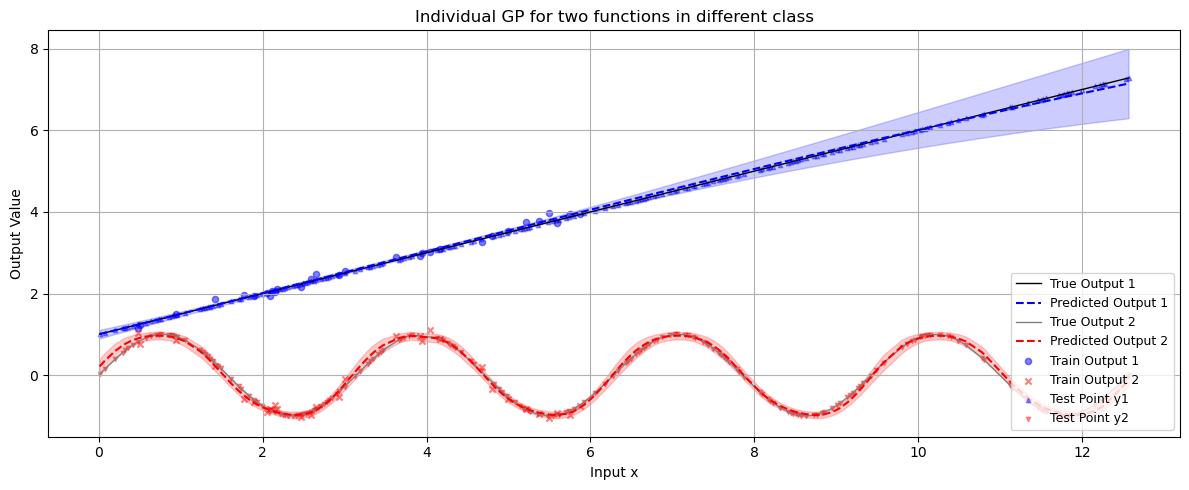

In [725]:
# plot predictions and uncertainties with training and test points highlighted
fig, ax = plt.subplots(figsize=(12, 5))

X_train_flat = X_train.flatten()
X_test_flat = X_test.flatten()

# plot true and predicted for output 1
ax.plot(X_test, y1_test, label="True Output 1", color="black", linewidth=1)
ax.plot(X_test, mu_0, label="Predicted Output 1", linestyle="--", color="blue")
ax.fill_between(X_test_flat,
                mu_0 - 2 * std_0,
                mu_0 + 2 * std_0,
                color="blue", alpha=0.2)

# plot true and predicted for output 2
ax.plot(X_test, y2_test, label="True Output 2", color="gray", linewidth=1)
ax.plot(X_test, mu_1, label="Predicted Output 2", linestyle="--", color="red")
ax.fill_between(X_test_flat,
                mu_1 - 2 * std_1,
                mu_1 + 2 * std_1,
                color="red", alpha=0.2)

# training points
ax.scatter(X_train, y1_train, color="blue", s=20, label="Train Output 1", alpha=0.5, marker='o')
ax.scatter(X_train, y2_train, color="red", s=20, label="Train Output 2", alpha=0.5, marker='x')

# test points (without noise)
ax.scatter(X_test, y1_test, color="blue", s=10, label="Test Point y1", alpha=0.4, marker='^')
ax.scatter(X_test, y2_test, color="red", s=10, label="Test Point y2", alpha=0.4, marker='v')

# settings
ax.set_title("Individual GP for two functions in different class")
ax.set_xlabel("Input x")
ax.set_ylabel("Output Value")
ax.legend(loc="lower right", fontsize=9)
ax.grid(True)

plt.tight_layout()
plt.show()

## Using the MOGP with SLFM approach for modeling these function

In [727]:
# !pip install GPy

In [728]:
import GPy

X1 = X_train.copy()                          # (N, 1)
Y1 = y1_train.reshape(-1, 1)

X2 = X_train.copy()
Y2 = y2_train.reshape(-1, 1)

X_list = [X1, X2]
Y_list = [Y1, Y2]

In [744]:
# from GPy.util.multioutput import LCM

kern_list = []

for _ in range(2):  # 2 latent functions
    # define SE and Periodic components
    k_se = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
    k_per = GPy.kern.StdPeriodic(input_dim=1, variance=1.0, lengthscale=1.0, period=np.pi)
    
    # apply constraints to keep optimization stable
    k_se.variance.constrain_bounded(1e-3, 15.0)
    k_se.lengthscale.constrain_bounded(1e-3, 15.0)

    k_per.variance.constrain_bounded(0.1, 5.0)
    k_per.lengthscale.constrain_bounded(0.1, 5.0)
    k_per.period.constrain_bounded(0.5, 10.0)

    # combine them into one kernel per latent function
    kern_list.append(k_se + k_per)

# Construct the LCM (Linear Coregionalization Model) kernel
lcm_kernel = LCM(input_dim=1, num_outputs=2, kernels_list=kern_list)

reconstraining parameters rbf.variance
reconstraining parameters rbf.lengthscale
reconstraining parameters std_periodic.variance
reconstraining parameters std_periodic.lengthscale
reconstraining parameters std_periodic.period
reconstraining parameters rbf.variance
reconstraining parameters rbf.lengthscale
reconstraining parameters std_periodic.variance
reconstraining parameters std_periodic.lengthscale
reconstraining parameters std_periodic.period


In [746]:
## Using linear kernel + period kernel for modeling two functions that totally different
# kern_list = []
# for _ in range(2):  # 2 latent functions
#     # Define Linear and Periodic components
#     k_lin = GPy.kern.Linear(input_dim=1, variances=1.0)
#     k_per = GPy.kern.StdPeriodic(input_dim=1, variance=1.0, lengthscale=1.0, period=np.pi)
    
#     # Apply constraints to keep optimization stable
#     k_lin.variances.constrain_bounded(1e-3, 15.0)

#     k_per.variance.constrain_bounded(1e-3, 15.0)
#     k_per.lengthscale.constrain_bounded(0.1, 5.0)
#     k_per.period.constrain_bounded(0.5, 10.0)

#     # Combine into one kernel per latent function
#     kern_list.append(k_lin + k_per)

# # Construct the Linear Coregionalization Model (LCM) kernel
# lcm_kernel = LCM(input_dim=1, num_outputs=2, kernels_list=kern_list)

In [748]:
model = GPy.models.GPCoregionalizedRegression(X_list, Y_list, kernel=lcm_kernel)
model.optimize(messages=True)

In [749]:
# Create test sets with index 0 and 1
Xtest_0 = np.hstack([X_test, np.zeros_like(X_test)])
Xtest_1 = np.hstack([X_test, np.ones_like(X_test)])

# Create metadata
Y_metadata_0 = {'output_index': np.zeros((X_test.shape[0], 1), dtype=int)}
Y_metadata_1 = {'output_index': np.ones((X_test.shape[0], 1), dtype=int)}

# Predict with metadata
mu_0, var_0 = model.predict(Xtest_0, Y_metadata=Y_metadata_0)
mu_1, var_1 = model.predict(Xtest_1, Y_metadata=Y_metadata_1)

In [750]:
from sklearn.metrics import mean_squared_error

mse_0 = mean_squared_error(y1_test, mu_0)
mse_1 = mean_squared_error(y2_test, mu_1)
lml_lib = model.log_likelihood()


In [751]:
print("MSE output 1:", mse_0)
print("MSE output 2:", mse_1)
print("Log Marginal Likelihood:", lml_lib)

MSE output 1: 0.036584891852038705
MSE output 2: 0.005131479944608766
Log Marginal Likelihood: 35.78235171982512


In [756]:
model.sum

sum.,value,constraints,priors
ICM0.sum.rbf.variance,0.001,"0.001,15.0",
ICM0.sum.rbf.lengthscale,15.0,"0.001,15.0",
ICM0.sum.std_periodic.variance,5.0,"0.1,5.0",
ICM0.sum.std_periodic.period,3.1824656782856233,"0.5,10.0",
ICM0.sum.std_periodic.lengthscale,5.0,"0.1,5.0",
ICM0.B.W,"(2, 1)",,
ICM0.B.kappa,"(2,)",+ve,
ICM1.sum.rbf.variance,15.0,"0.001,15.0",
ICM1.sum.rbf.lengthscale,15.0,"0.001,15.0",
ICM1.sum.std_periodic.variance,0.1,"0.1,5.0",


In [758]:
A1 = model.sum.ICM0.B.W
A2 = model.sum.ICM1.B.W

In [760]:
A1

index,gp.sum.ICM0.B.W,constraints,priors
[0 0],0.03818996,,
[1 0],-2.32261276,,


In [762]:
A2

index,gp.sum.ICM1.B.W,constraints,priors
[0 0],1.25452852,,
[1 0],-0.01450461,,


In [764]:
std_0 = np.sqrt(var_0)
std_1 = np.sqrt(var_1)

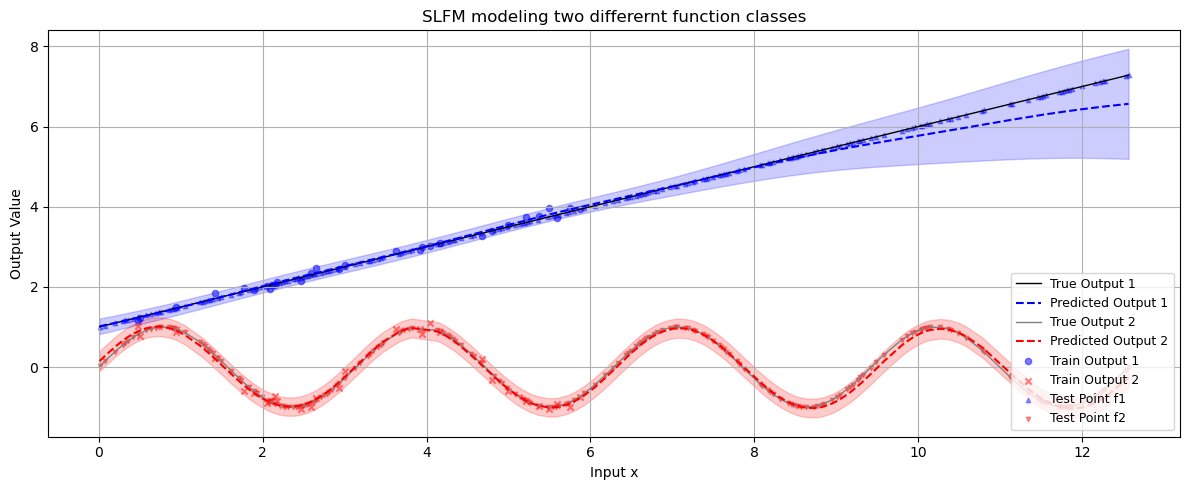

In [769]:
# plot predictions and uncertainties with training and test points highlighted
fig, ax = plt.subplots(figsize=(12, 5))

X_train_flat = X_train.flatten()
X_test_flat = X_test.flatten()

# plot true and predicted for Output 1
ax.plot(X_test, y1_test, label="True Output 1", color="black", linewidth=1)
ax.plot(X_test, mu_0[:,0], label="Predicted Output 1", linestyle="--", color="blue")
ax.fill_between(X_test_flat,
                mu_0[:,0] - 2 * std_0[:,0],
                mu_0[:,0] + 2 * std_0[:,0],
                color="blue", alpha=0.2)

# plot true and predicted for Output 2
ax.plot(X_test, y2_test, label="True Output 2", color="gray", linewidth=1)
ax.plot(X_test, mu_1[:,0], label="Predicted Output 2", linestyle="--", color="red")
ax.fill_between(X_test_flat,
                mu_1[:,0] - 2 * std_1[:,0],
                mu_1[:,0] + 2 * std_1[:,0],
                color="red", alpha=0.2)

# training points
ax.scatter(X_train, y1_train, color="blue", s=20, label="Train Output 1", alpha=0.5, marker='o')
ax.scatter(X_train, y2_train, color="red", s=20, label="Train Output 2", alpha=0.5, marker='x')

# test points (without noise)
ax.scatter(X_test, y1_test, color="blue", s=10, label="Test Point f1", alpha=0.4, marker='^')
ax.scatter(X_test, y2_test, color="red", s=10, label="Test Point f2", alpha=0.4, marker='v')

# settings
ax.set_title("SLFM modeling two differernt function classes")
ax.set_xlabel("Input x")
ax.set_ylabel("Output Value")
ax.legend(loc="lower right", fontsize=9)
ax.grid(True)

plt.tight_layout()
plt.show()
